### Fashion AI - Personal Stylist 

This notebook focuses on Outfit Builder (Cross-sell) using the dataset on Myntra from kaggle (https://www.kaggle.com/datasets/djagatiya/myntra-fashion-product-dataset?resource=download).

Overview of Outfit Builder (Cross-sell) AI use case illustration:
- User Query: What goes well with thhe blue denim jacket?
- Retreival: Fetch products tagged as bottoms, shoes, or accessories with embeddings.
- Generate:  Suggest styled combinations:
“Pair this denim jacket with black skinny jeans and white sneakers for a casual street look. Or try it over a floral dress for contrast.”

Technical implementation:
1. Data Exploration - Know your data
2. Data Preparation - Chunking strategies
3. Embed the data with vector DB layer
4. User query embeddings  layer
5. Re-Ranking layer
6. Generative Search layer
7. Build a RAG pipeline connecting all these layers
8. Evaluation 


In [1]:
### Installing ChromaDB
#!pip install chromadb

In [2]:
# !pip install transformers
# !pip install sentence-transformers

In [3]:
# ! pip install --upgrade openai

### 0. Importing Libraries

In [4]:
### Necessary library imports
import os
import pandas as pd 
import numpy as np 
import ast
import json
import matplotlib.pyplot as plt
import re

### importing vector database
import chromadb as chroma
chroma_client=chroma.PersistentClient(path="./chroma_db")

### import libabries for sentence transformer
from sentence_transformers import SentenceTransformer
model=SentenceTransformer('all-MiniLM-L6-v2')

### importing LLM model
from openai import OpenAI
with open("C:/Users/SHAMBHAVVISEN/Downloads/OpenAI_API_Key.txt","r") as file:
    api_key=file.read().strip()
openai_client=OpenAI(api_key=api_key)



c:\Users\SHAMBHAVVISEN\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Data Exploration

In [5]:
## 1.1. Reading the data
myntra_db=pd.read_csv("Fashion Dataset v2.csv")
myntra_db.head(2)

,p_id,name,products,price,colour,brand,img,ratingCount,avg_rating,description,p_attributes
0,17048614,Khushal K Women Black Ethnic Motifs Printed Ku...,"Kurta, Palazzos, Dupatta",5099.0,Black,Khushal K,http://assets.myntassets.com/assets/images/170...,4522.0,4.418399,Black printed Kurta with Palazzos with dupatta...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."
1,16524740,InWeave Women Orange Solid Kurta with Palazzos...,"Kurta, Palazzos, Floral Print Dupatta",5899.0,Orange,InWeave,http://assets.myntassets.com/assets/images/165...,1081.0,4.119334,Orange solid Kurta with Palazzos with dupatta<...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."


In [6]:
myntra_db.columns
### 1.2. Checking for Null values
myntra_db.isnull().sum()/len(myntra_db)*100

p_id             0.000000
name             0.000000
products         0.000000
price            0.000000
colour           0.000000
brand            0.000000
img              0.000000
ratingCount     54.059378
avg_rating      54.059378
description      0.000000
p_attributes     0.000000
dtype: float64

Only ratingCount and avg_rating has 54% of missing values. These two fields are metadata worthy but not gonna be involved into Sentence embeddings. However it is a good candidate for metadata

In [7]:
### Count the length of text in each row of 'name', 'product' and 'description' columns
def count_text_length(db,columns):
    """
    This function takes a dataframe and a list of column names as input. 
    It calculates the length of text in each specified column and adds a new column with the suffix '_length
    """
    for col in columns:
        db[col+"_length"]=db[col].apply(lambda x: len(str(x)))
    return db
count_text_length(myntra_db,['name','products','description','p_attributes'])
myntra_db[['name_length', 'products_length', 'description_length',
       'p_attributes_length']].max()

name_length             108
products_length          76
description_length     1670
p_attributes_length    1452
dtype: int64

In [8]:
myntra_db[['name_length', 'products_length', 'description_length',
       'p_attributes_length']].describe()

,name_length,products_length,description_length,p_attributes_length
count,14214.000000,14214.000000,14214.000000,14214.000000
mean,56.115590,9.842690,304.017377,570.252005
std,16.022154,6.772937,175.988607,205.259958
min,15.000000,1.000000,26.000000,20.000000
25%,44.000000,5.000000,174.000000,415.000000
50%,54.000000,8.000000,251.000000,584.000000
75%,66.000000,13.000000,376.000000,656.000000
max,108.000000,76.000000,1670.000000,1452.000000


### 2. Data Preparation

In [9]:
### 2.1. Data Cleaning
def normalize_json(data, column):
    """
    data: pandas dataframe
    column: column name which contains json as string
    returns the normalized text function
    """
    data[column+'_cleaned']=data[column].apply(lambda x: x.replace(":","").replace("{","").replace("}","").replace("[","").replace("]","").replace("'","").replace('"',"") if pd.notnull(x) else "")
    return data
    

In [10]:
normalize_json(myntra_db,'p_attributes')

myntra_db['description_cleaned']=myntra_db['description'].apply(lambda x: re.sub("<.*?>","",str(x).strip()))
print(myntra_db['description'][0])
print(myntra_db['description_cleaned'][0])

Black printed Kurta with Palazzos with dupatta <br> <br> <b> Kurta design:  </b> <ul> <li> Ethnic motifs printed </li> <li> Anarkali shape </li> <li> Regular style </li> <li> Mandarin collar,  three-quarter regular sleeves </li> <li> Calf length with flared hem </li> <li> Viscose rayon machine weave fabric </li> </ul> <br> <b> Palazzos design:  </b> <ul> <li> Printed Palazzos </li> <li> Elasticated waistband </li> <li> Slip-on closure </li> </ul>Dupatta Length 2.43 meters Width:&nbsp;88 cm<br>The model (height 5'8) is wearing a size S100% Rayon<br>Machine wash
Black printed Kurta with Palazzos with dupatta    Kurta design:     Ethnic motifs printed   Anarkali shape   Regular style   Mandarin collar,  three-quarter regular sleeves   Calf length with flared hem   Viscose rayon machine weave fabric     Palazzos design:     Printed Palazzos   Elasticated waistband   Slip-on closure  Dupatta Length 2.43 meters Width:&nbsp;88 cmThe model (height 5'8) is wearing a size S100% RayonMachine wash

In [11]:
myntra_db['description_cleaned']=myntra_db['description'].apply(lambda x: re.sub("<.*?>","",str(x).strip()))
print("Before cleaning:", myntra_db['description'][0])
print("After cleaning:",myntra_db['description_cleaned'][0])

### Concatenating the name, product, description and p_attributes columns for embedding
myntra_db["combined_text_to_embded"]=myntra_db["name"].astype(str)+"\n" + myntra_db["products"].astype(str)+"\n"+myntra_db["description_cleaned"].astype(str)+"\n"+myntra_db["p_attributes_cleaned"].astype(str)
count_text_length(myntra_db,["combined_text_to_embded"])
print("\nTotal number of tokens to be embedded:")
myntra_db[["name_length","products_length","description_length","combined_text_to_embded_length"]].describe()

Before cleaning: Black printed Kurta with Palazzos with dupatta <br> <br> <b> Kurta design:  </b> <ul> <li> Ethnic motifs printed </li> <li> Anarkali shape </li> <li> Regular style </li> <li> Mandarin collar,  three-quarter regular sleeves </li> <li> Calf length with flared hem </li> <li> Viscose rayon machine weave fabric </li> </ul> <br> <b> Palazzos design:  </b> <ul> <li> Printed Palazzos </li> <li> Elasticated waistband </li> <li> Slip-on closure </li> </ul>Dupatta Length 2.43 meters Width:&nbsp;88 cm<br>The model (height 5'8) is wearing a size S100% Rayon<br>Machine wash
After cleaning: Black printed Kurta with Palazzos with dupatta    Kurta design:     Ethnic motifs printed   Anarkali shape   Regular style   Mandarin collar,  three-quarter regular sleeves   Calf length with flared hem   Viscose rayon machine weave fabric     Palazzos design:     Printed Palazzos   Elasticated waistband   Slip-on closure  Dupatta Length 2.43 meters Width:&nbsp;88 cmThe model (height 5'8) is weari

,name_length,products_length,description_length,combined_text_to_embded_length
count,14214.000000,14214.000000,14214.000000,14214.000000
mean,56.115590,9.842690,304.017377,800.286408
std,16.022154,6.772937,175.988607,268.189975
min,15.000000,1.000000,26.000000,158.000000
25%,44.000000,5.000000,174.000000,641.000000
50%,54.000000,8.000000,251.000000,765.000000
75%,66.000000,13.000000,376.000000,929.000000
max,108.000000,76.000000,1670.000000,2492.000000


In [12]:
myntra_db[["name","products","description_cleaned","p_attributes_cleaned","combined_text_to_embded"]].head(2)

,name,products,description_cleaned,p_attributes_cleaned,combined_text_to_embded
0,Khushal K Women Black Ethnic Motifs Printed Ku...,"Kurta, Palazzos, Dupatta",Black printed Kurta with Palazzos with dupatta...,"Add-Ons NA, Body Shape ID 443,333,324,424, Bod...",Khushal K Women Black Ethnic Motifs Printed Ku...
1,InWeave Women Orange Solid Kurta with Palazzos...,"Kurta, Palazzos, Floral Print Dupatta",Orange solid Kurta with Palazzos with dupattaK...,"Add-Ons NA, Body Shape ID 443,333,324,424, Bod...",InWeave Women Orange Solid Kurta with Palazzos...


The maximum tokens for embedding is 2492. So I choose not to truncate or limit the tokens 

### 3. Sentence Embedding 

In [13]:
### 3. Embed the text data using chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

### Create a collection in chromadb
collection=chroma_client.get_or_create_collection(name="myntra_fashion_collection",
                                                  embedding_function=OpenAIEmbeddingFunction(
                                                      api_key=api_key,model_name="text-embedding-ada-002"
                                                      )
                                                      ) 
### Add the data to the collection
batch_size =100

for i in range(0, myntra_db.shape[0], batch_size):
    print(f"Processing batch {i//batch_size + 1}")
    batch=myntra_db.iloc[i:i+batch_size]

    
    collection.add(
        documents=batch["combined_text_to_embded"].astype(str).to_list(),
        metadatas=batch.apply(lambda x: {'Product_ID': x['p_id'],'Price': x['price'], 'Brand': x['brand'], 'Image':x['img']},axis=1).to_list(),
        ids=[str(j) for j in range(i, i + len(batch))]
    )

Processing batch 1
Processing batch 2
Processing batch 3
Processing batch 4
Processing batch 5
Processing batch 6
Processing batch 7
Processing batch 8
Processing batch 9
Processing batch 10
Processing batch 11
Processing batch 12
Processing batch 13
Processing batch 14
Processing batch 15
Processing batch 16
Processing batch 17
Processing batch 18
Processing batch 19
Processing batch 20
Processing batch 21
Processing batch 22
Processing batch 23
Processing batch 24
Processing batch 25
Processing batch 26
Processing batch 27
Processing batch 28
Processing batch 29
Processing batch 30
Processing batch 31
Processing batch 32
Processing batch 33
Processing batch 34
Processing batch 35
Processing batch 36
Processing batch 37
Processing batch 38
Processing batch 39
Processing batch 40
Processing batch 41
Processing batch 42
Processing batch 43
Processing batch 44
Processing batch 45
Processing batch 46
Processing batch 47
Processing batch 48
Processing batch 49
Processing batch 50
Processin

In [14]:
collection.peek(2)

{'ids': ['0', '1'],
 'embeddings': array([[-0.03388046,  0.00139618,  0.01412588, ...,  0.01344935,
          0.0088625 , -0.01913217],
        [-0.01416636, -0.00502926, -0.00019381, ...,  0.00176744,
          0.0110838 , -0.02460684]]),
 'documents': ["Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta\nKurta, Palazzos, Dupatta\nBlack printed Kurta with Palazzos with dupatta    Kurta design:     Ethnic motifs printed   Anarkali shape   Regular style   Mandarin collar,  three-quarter regular sleeves   Calf length with flared hem   Viscose rayon machine weave fabric     Palazzos design:     Printed Palazzos   Elasticated waistband   Slip-on closure  Dupatta Length 2.43 meters Width:&nbsp;88 cmThe model (height 5'8) is wearing a size S100% RayonMachine wash\nAdd-Ons NA, Body Shape ID 443,333,324,424, Body or Garment Size Garment Measurements in, Bottom Closure Slip-On, Bottom Fabric Viscose Rayon, Bottom Pattern Printed, Bottom Type Palazzos, Character NA, D

### 4. User query embeddings

- 4.1 Implementating cache
- 4.2 Intent layer - Parsing the intent of the query for semantic search

In [58]:
query="Get a kurta set with emboidary designs under 3500"
query

'Get a kurta set with emboidary designs under 3500'

In [59]:
### 4.2 Intent layer - Parsing the intent of the query for semantic search]
def parse_intent(query):
    """
    Takes a user query and extracts structured attributes as JSON.
    """
    prompt = """
    You are an expert fashion outfit builder. 
    Extract relevant attributes from the user's query as a valid JSON object. 
    The attributes to consider are: color, style, material, pattern, occasion, price, and brand.
    If an attribute is not mentioned, set its value to any
    Required JSON schema:
    {
        "intent": string,
        "base_items": [list of strings],
        "target_categories": [list of strings],
        "filters": {
            "color": string,
            "style": string,
            "material": string,
            "pattern": string,
            "occasion": string,
            "price": string,
            "brand": string
        }
    }
    Always return valid JSON, no extra text.
    """

    response = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",  
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": f"User Query: {query}"}
        ],
        max_tokens=200
    )

    raw_output = response.choices[0].message.content.strip()
    
    try:
        parsed_output = json.loads(raw_output)  # safely parse JSON
    except json.JSONDecodeError:
        print("Model returned invalid JSON, here’s the raw output:")
        print(raw_output)
        parsed_output = {}

    return parsed_output
parsed_intent = parse_intent(query)
parsed_intent

{'intent': 'Get',
 'base_items': ['kurta set'],
 'target_categories': ['embroidery designs'],
 'filters': {'color': 'any',
  'style': 'any',
  'material': 'any',
  'pattern': 'any',
  'occasion': 'any',
  'price': 'under 3500',
  'brand': 'any'}}

In [60]:
## 4.1 Implementing Cache for storing previous queries and results

### Creating separate collection for cache
cache_collection=chroma_client.get_or_create_collection(name="cache_collection",
                                                  embedding_function=OpenAIEmbeddingFunction(
                                                      api_key=api_key,model_name="text-embedding-ada-002"
                                                      )
                                                      )

### Creating dummy entry in cache collection
cache_collection.add(
    documents=["test entry"], 
    metadatas=[{"results": "dummy"}], 
    ids=["test1"]
)
### checking the cache collection
cache_results=cache_collection.query(
    query_texts=query,
    n_results=1
)


cache_results

def cache_implementation(query,main_collection,cache_collection,cache_results, parsed_intent, threshold=0.1):
    if cache_results['distances'][0]==[] or cache_results['distances'][0][0]>threshold:
        print("Fetching from main fashion AI collection")
        ### Making the semantic query by appending the parsed intent to the original query
        semantic_query = (
    f"{parsed_intent['intent']} "
    f"with {parsed_intent['target_categories']} "
    f"to pair with {parsed_intent['base_items']}. "
    f"Filters: color={parsed_intent['filters']['color']}, "
    f"style={parsed_intent['filters']['style']}, "
    f"material={parsed_intent['filters']['material']}, "
    f"pattern={parsed_intent['filters']['pattern']}, "
    f"occasion={parsed_intent['filters']['occasion']}, "
    f"price={parsed_intent['filters']['price']}, "
    f"brand={parsed_intent['filters']['brand']}."
)
        # print("Semantic query:", semantic_query)
        results = main_collection.query(
            query_texts=[semantic_query],
            n_results=10,
            include=["documents", "metadatas", "distances"]
        )
        cache_collection.add(
            documents=[semantic_query],
            metadatas=[{'results': json.dumps(results)}],
            ids=[query]
        )
        result_df=pd.DataFrame({'ids':results['ids'][0],#'Product_ID':[item['Product_ID'] for item in cached_data['metadatas'][0]],
                                'documents':results['documents'][0],'distances':results['distances'][0],'Image':[item['Image'] for item in results['metadatas'][0]],})

    elif cache_results['distances'][0][0]<=threshold:
        print("Fetching from cache collection")
       ### the results are in json string hence converting it back to dictionary
        cached_data=json.loads(cache_results['metadatas'][0][0]['results'])
        # print(cached_data)
        result_df=pd.DataFrame({'ids':cached_data['ids'][0],#'Product_ID':[item['Product_ID'] for item in cached_data['metadatas'][0]],
                                'documents':cached_data['documents'][0],'distances':cached_data['distances'][0],'Image':[item['Image'] for item in cached_data['metadatas'][0]],})
    return semantic_query,result_df

In [61]:

user_query,results=cache_implementation(query,collection,cache_collection,cache_results,parsed_intent,threshold=0.1)
print("User Query:", user_query )
results

Fetching from main fashion AI collection
User Query: Get with ['embroidery designs'] to pair with ['kurta set']. Filters: color=any, style=any, material=any, pattern=any, occasion=any, price=under 3500, brand=any.


,ids,documents,distances,Image
0,293,all about you Women Yellow & Green Embroidered...,0.260537,http://assets.myntassets.com/assets/images/169...
1,672,all about you Women Blue & Yellow Ethnic Motif...,0.270099,http://assets.myntassets.com/assets/images/169...
2,616,Tikhi Imli Women Red Pure Cotton Ethereal Embr...,0.271841,http://assets.myntassets.com/assets/images/186...
3,572,Indo Era Grey Silk Blend Scalloped Edge Kurta ...,0.272723,http://assets.myntassets.com/assets/images/167...
4,586,KETCH Women Yellow & Blue Ethnic Motifs Printe...,0.272883,http://assets.myntassets.com/assets/images/161...
5,744,FASHOR Women Pink Floral Embroidered Straight ...,0.274143,http://assets.myntassets.com/assets/images/191...
6,80,Indo Era Women Pink Ethnic Motifs Embroidered ...,0.274833,http://assets.myntassets.com/assets/images/181...
7,865,Indo Era Embroidered Velvet Kurta Set\nKurta S...,0.274853,http://assets.myntassets.com/assets/images/157...
8,387,all about you Women Pink & Gold-Toned Embroid...,0.275674,http://assets.myntassets.com/assets/images/147...
9,840,all about you Women Navy Blue & Silver-Toned E...,0.275786,http://assets.myntassets.com/assets/images/178...


In [62]:
results.Image.loc[2]

'http://assets.myntassets.com/assets/images/18615962/2022/7/21/d07d3bc6-2d46-4446-b6ab-ba4fa1d4c93c1658408687796-Tikhi-Imli-Women-Kurta-Sets-7461658408687277-1.jpg'

### 5. Re-Ranking 

Re-scoring the top 10 results 

In [63]:
### 5.1. Importing the r-ranking model
from sentence_transformers import CrossEncoder,util
reranker=CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2')

In [64]:
### 5.2 Re-Ranking function
def rerank_results(query,results,reranker,top_k=5):
    """
    Re-Ranking the results based on the relevance to the user query
    """
    ### Preparing the input for cross_encoder
    cross_inputs=[[query,doc] for doc in results['documents']]
    
    ### Getting the relevance scores from the cross encoder
    results['relevance_scores']=reranker.predict(cross_inputs,convert_to_numpy=True)#,apply_softmax=True)

    ### Sorting the results based on relevance scores
    reranked_results=results.sort_values(by='relevance_scores',ascending=False).head(top_k).reset_index(drop=True)
    return reranked_results

In [65]:
results=rerank_results(user_query,results,reranker,top_k=3)
results

,ids,documents,distances,Image,relevance_scores
0,616,Tikhi Imli Women Red Pure Cotton Ethereal Embr...,0.271841,http://assets.myntassets.com/assets/images/186...,1.663491
1,572,Indo Era Grey Silk Blend Scalloped Edge Kurta ...,0.272723,http://assets.myntassets.com/assets/images/167...,0.414466
2,865,Indo Era Embroidered Velvet Kurta Set\nKurta S...,0.274853,http://assets.myntassets.com/assets/images/157...,-0.290024


In [66]:
results.Image.loc[0]

'http://assets.myntassets.com/assets/images/18615962/2022/7/21/d07d3bc6-2d46-4446-b6ab-ba4fa1d4c93c1658408687796-Tikhi-Imli-Women-Kurta-Sets-7461658408687277-1.jpg'

### 6. Generative Search Layer

1. Given the user query and results with re-ranked relevant scores. Generative response using GPT will provided in this layer
2. Based on the suggested response revelant images will be opened


In [67]:
def generative_response(query,db,results,openai_client,max_tokens=500):
    """
    Generates response based on user query and  top-k re-ranked results
    Displays the images of the top 3 products
    """
    messages=[
        {"role":"system",'content': "You are an expert fashion stylist. Given the user_query and the top 5 relevant products, suggest an outfit for an requested occassion"},
        {"role":"user", 'content': f"User_query: {query} \n Top 5 relevant products:{results['documents'].to_list()}"},
        {"role":"assistant",
         "content": f"""
         Use the {results} to suggest an outfit for the {query} by comparing the price, brands and styles of the products matched with {myntra_db} 
         using {results['ids'].to_list()}
        You are a fashion stylist. Only suggest outfits using the products provided below.
        Do not invent or mention any other items. Always use the product name as given.
            1. Provide a creative and human-like response on the chosen outfit for the {query}
            2. Suggest 3 products from the matched results
            3. Provide a humorous reasoning for choosing the products
        The overall summary should be in conversational tone with functional and emotional appeal.
        """
        }         
    ]

    response = openai_client.chat.completions.create(
        model="gpt-4o-mini",  
        messages=messages,
        max_tokens=max_tokens,
        temperature=0,
        # functions=functions,
        # function_call="auto"
    )
    fig,axes=plt.subplots(figsize=(10,10),nrows=1,ncols=len(results.ids.to_list()[:3]))
    for ax,i in zip(axes.ravel(),results.ids.to_list()[:3]):
        # ax,plt=plt.subplots(figsize=(1,))
        img=db.p_id.loc[int(i)]
        ax.imshow(plt.imread(f"images/{img}.jpg"))
        ax.axis('off')
        
    return print(response.choices[0].message.content.strip())

Absolutely! Let’s create a stunning outfit that perfectly embodies the charm of embroidery designs paired with a kurta set. 

### Outfit Suggestion:
**Kurta Set:** **Tikhi Imli Women Red Pure Cotton Ethereal Embroidery Kurta Set**  
This gorgeous deep red kurta set is not just a feast for the eyes but also a celebration of comfort with its pure cotton fabric. The intricate embroidery adds a touch of sophistication, making it perfect for festive occasions or family gatherings. 

**Accessories:**  
1. **Statement Earrings:** Opt for some glittering teardrop earrings to add a dash of sparkle. They’ll catch the light just like your personality!
2. **Mojaris with Mirror Work:** These traditional shoes will not only keep your feet comfy but also elevate your ethnic look. Plus, they’re perfect for dancing at family functions—just in case the DJ plays your jam!
3. **Cute Metal Nose Ring:** A little bling on your nose can go a long way in enhancing your overall look. It’s like the cherry on top

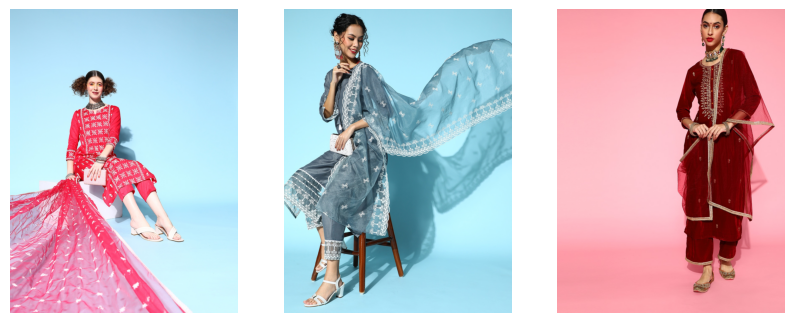

In [68]:
generative_response(user_query,myntra_db,results,openai_client,max_tokens=500)

### 7. RAG Pipeline

In [43]:
def fashion_RAG_pipeline(db,main_collection,cache_colllection,cache_results,threshold=0.1):
        
        """
        End to End RAG Pipeline for Fashion Outfit Builder
        1. Takes user query as input    
        2. Parses the intent of the query
        3. Checks the cache for previous similar queries
        4. If not found in cache, fetches results from main collection
        5. Re-ranks the results using cross-encoder
        6. Generates a creative response using GPT-3.5-turbo
        """
        print("Outfit Builder - Fashion AI Search System")
            ### 1. Taking user query as input
        query=input("Enter your fashion request: ")
        print(f"User requirement: {query}")

        ### 2. Parsing the intent of the query
        parsed_intent = parse_intent(query)

        ### 3. Cache implementation &  4. Fetching results from main collection if not found in cache
        user_query, results=cache_implementation(query,main_collection,cache_collection,cache_results, parsed_intent,threshold=0.1)

        ### 5. Re-ranking the results
        results=rerank_results(user_query,results,reranker,top_k=3)

        ### 6. Generative response using GPT-3.5-turbo
        return generative_response(user_query,db,results,openai_client,max_tokens=500)

    
        

### 8. Evaluations

Outfit Builder - Fashion AI Search System
User requirement: Get a kurta set with emboidary designs under 3500
Fetching from main fashion AI collection
For your occasion of pairing an embroidered piece with a kurta set, I've curated a delightful outfit that will have you looking stunning and feeling fabulous! Here’s what I suggest:

### Outfit Suggestion:
1. **Indo Era Grey Silk Blend Scalloped Edge Kurta Set**  
   - This beautiful grey kurta set features a gorgeous tie-up neck and three-quarter sleeves, perfect for a festive occasion. The scalloped edges and embroidered details add a touch of elegance that will make you the star of any gathering!

2. **Indo Era Embroidered Velvet Kurta Set**  
   - In a rich red tone, this kurta set is not just a feast for the eyes but also a luxurious experience with its velvet fabric. The round neck and palazzos make it a comfortable yet chic choice for any festive celebration.

3. **All About You Women Yellow & Green Embroidered Kurta**  
   - Brig

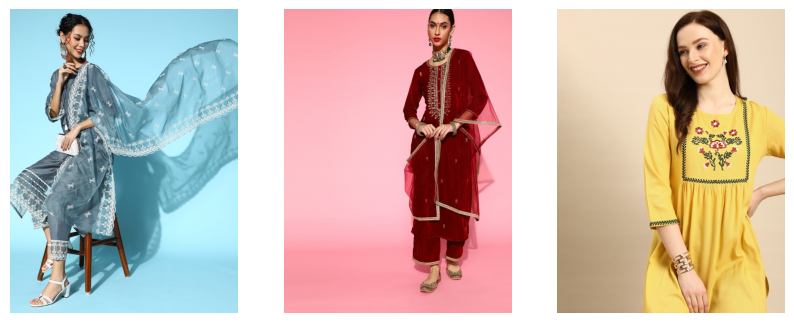

In [44]:
fashion_RAG_pipeline(myntra_db,collection,cache_collection,cache_results,threshold=0.1)

The user's request and the obtained results are perfectly matching for various query statements. In addition to that, the generated resposne in a humourous, sensible and blissful tone. 